In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

import joblib

The set of phishing URLs are collected from opensource service called PhishTank. Individual Datasets were taken, cleaned, processed and combined into one single dataset.  

https://www.phishtank.com/developer_info.php.  
https://www.kaggle.com/datasets/ndarvind/phiusiil-phishing-url-dataset  
https://github.com/chamanthmvs/Phishing-Website-Detection/blob/master/raw_datasets/1000-phishing.txt  

Refer the data processing notebooks to understand the dataset combination process and methods used to extract some of the important features.

In [2]:
df1 = pd.read_csv('FINAL.csv')
df1.head(5)

,Unnamed: 0,URL,URL Length,Digits count,URL Depth,URL Entropy,URL Popularity Score,Domain,Sub-domain count,Domain Entropy,Path length,Special Characters count,Has https,Has IP,Has Suspicious keywords,TLD,Has Suspicious TLD,Label,Target
0,0,https://www.google.com,22,0,0,3.7,12,google.com,1,-1.9,0,3,Yes,No,No,com,No,legitimate,0
1,1,https://www.youtube.com,23,0,0,3.8,12,youtube.com,1,-1.8,0,3,Yes,No,No,com,No,legitimate,0
2,2,https://www.facebook.com,24,0,0,3.9,12,facebook.com,1,-1.8,0,3,Yes,No,No,com,No,legitimate,0
3,3,https://www.baidu.com,21,0,0,3.9,12,baidu.com,1,-1.7,0,3,Yes,No,No,com,No,legitimate,0
4,4,https://www.wikipedia.org,25,0,0,3.8,12,wikipedia.org,1,-1.7,0,3,Yes,No,No,org,No,legitimate,0


The Dataset contains:
- Legitimate (0) = 345,738
- Phishing (1) = 206,381

### Functions Used for Data Extraction

In [2]:
## Yes = 1
## No = 0

def get_url_len(url):
    return len(url)

def count_digits(url):
    count = 0
    for i in url:
        if '0' <= i <= '9':
            count += 1
    return count

def count_url_depth(url):
    url1 = url.split("://")[-1]
    return url1.count('/')

def entropy(url):
    frequency = {}
    for char in url:
        if char in frequency:
            frequency[char] += 1
        else:
            frequency[char] = 1

    entropy = 0.0
    length = len(url)
    for count in frequency.values():
        probability = count / length
        if probability > 0:
            entropy -= probability * math.log2(probability)
    return round(entropy, 1) 

def popularity_score(url):
    popular_tlds = ['.com', '.org', '.net', '.gov', '.edu']
    
    tld_score = 5 if any(url.endswith(tld) for tld in popular_tlds) else 2

    if len(url) < 20:
        length_score = 5
    elif len(url) < 30:
        length_score = 3
    else:
        length_score = 1


    subdomain_count = url.count('.') - 1
    subdomain_score = max(1, 5 - subdomain_count)  

    score = tld_score + length_score + subdomain_score
    return score

def get_domain(url):
    if '://' in url:
        url = url.split('://')[1]
    if 'www.' in url:
        url = url.split('www.')[1]
    domain = url.split('/')[0]
    return domain

def count_subdomain(url):
    if '://' in url:
        url = url.split('://')[1]
    domain_part = url.split('/')[0]
    parts = domain_part.split('.')
    if len(parts) < 2:
        return 0
    return len(parts) - 2

def log2(x):
    return 3.321928094887362 * (x**(1/3.321928094887362))

def calculate_entropy(url):
    domain = get_domain(url)
    frequency = {}
    for char in domain:
        if char in frequency:
            frequency[char] += 1
        else:
            frequency[char] = 1
            
    total_chars = len(domain)
    
    entropy = 0.0
    for count in frequency.values():
        probability = count / total_chars
        entropy -= probability * (0 if probability == 0 else log2(probability))
    
    return round(entropy, 1) 

def path_length(url):
    path_start = url.find('/', url.find('//') + 2)
    
    if path_start == -1:
        return 0
    
    path_end = url.find('?') if '?' in url else len(url)
    path = url[path_start:path_end]
    
    return len(path)

def count_special_char(url):
    special_char = ['-', '_', '.', '=', '?', '&', '@', '#', '%', ':', '~']
    return sum(url.count(char) for char in special_char)

def has_https(url):
    if url.startswith('https://'):
        return 1
    else:
        return 0
    
def has_ip(url):
    main_part = url.split('/')[2] if '//' in url else url.split('/')[0]
    parts = main_part.split('.')
    
    if len(parts) == 4:
        for part in parts:
            if not part.isdigit() or not (0 <= int(part) <= 255):
                return 0
        return 1
    return 0

def has_suspicious_keywords(url):
    suspicious_keywords = [
        'login', 'verify', 'secure', 'account', 'pay',
        'bank', 'password', 'credential', 'bitcoin', 'confirm'
    ]
    url_lower = url.lower()
    
    for keyword in suspicious_keywords:
        if keyword in url_lower:
            return 1
    return 0

def get_tld(url):
    if '://' in url:
        url = url.split('://')[1]
    
    if url.startswith('www.'):
        url = url[4:]

    parts = url.split("/")[0].split(".")
    if len(parts) > 1:
        return parts[-1]
    return None

def has_suspicious_tld(url):
    suspicious_tlds = [
        "xyz", "top", "club", "online", "site", "win", "click", "link",
        "bid", "ga", "download", "buzz", "loan", "review",
        "men", "party", "top", "fun", "space",
        "pw", "cn", "tk", "work"
    ]

    tld = get_tld(url)

    if tld and tld in suspicious_tlds:
        return 1
    return 0


### Understanding the Data

In [4]:
df1.isna().sum()

Unnamed: 0                    0
URL                           0
URL Length                    0
Digits count                  0
URL Depth                     0
URL Entropy                   0
URL Popularity Score          0
Domain                        4
Sub-domain count              0
Domain Entropy                0
Path length                   0
Special Characters count      0
Has https                     0
Has IP                        0
Has Suspicious keywords       0
TLD                         228
Has Suspicious TLD            0
Label                         0
Target                        0
dtype: int64

Handeling Missing values for TDL

In [5]:
missing_tld = df1[df1['TLD'].isnull()]
print(f"Number of websites with missing TLD: {len(missing_tld)}")

Number of websites with missing TLD: 228


In [6]:
# Since there is only one legitimate website not having TDL, we can drop it 
missing_tld['Target']==0
df1.drop(index=214091, inplace=True)

In [7]:
# We will replace the TDL for Phishing by mode 
mode_tld_phishing = df1[df1['Target'] == 1]['TLD'].mode()[0]
mode_tld_phishing

'com'

In [8]:
df1.loc[df1['TLD'].isnull(), 'TLD'] = mode_tld_phishing

Handeling Missing values for Domain

In [9]:
missing_Domain = df1[df1['Domain'].isnull()]
missing_Domain

,Unnamed: 0,URL,URL Length,Digits count,URL Depth,URL Entropy,URL Popularity Score,Domain,Sub-domain count,Domain Entropy,Path length,Special Characters count,Has https,Has IP,Has Suspicious keywords,TLD,Has Suspicious TLD,Label,Target
728,728,https://www.www.gov.uk,22,0,0,3.4,8,NaN,2,0.0,0,4,Yes,No,No,uk,No,legitimate,0
402364,402364,http://www.www.dvdvision.webcindario.com/uiv58,46,2,1,4.1,5,NaN,3,0.0,6,5,No,No,No,com,No,phishing,1
402836,402836,http://www.www.www.www.lappeenrannankalevalais...,67,6,1,4.0,4,NaN,4,0.0,9,6,No,No,No,net,No,phishing,1
460596,460596,http://www.www.woodandthimble.com/www.labanque...,82,10,3,4.6,4,NaN,2,0.0,49,7,No,No,Yes,com,No,phishing,1


In [10]:
# Since there is only one legitimate website not having Domain, we can drop it 
df1.drop(index=728, inplace=True)

In [11]:
# We will replace the TDL for Phishing by mode 
mode_Domain_phishing = df1[df1['Target'] == 1]['Domain'].mode()[0]
mode_Domain_phishing

'ipfs.io'

In [12]:
df1.loc[df1['Domain'].isnull(), 'Domain'] = mode_Domain_phishing

In [13]:
df1.isna().sum()

Unnamed: 0                  0
URL                         0
URL Length                  0
Digits count                0
URL Depth                   0
URL Entropy                 0
URL Popularity Score        0
Domain                      0
Sub-domain count            0
Domain Entropy              0
Path length                 0
Special Characters count    0
Has https                   0
Has IP                      0
Has Suspicious keywords     0
TLD                         0
Has Suspicious TLD          0
Label                       0
Target                      0
dtype: int64

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551650 entries, 0 to 551651
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                551650 non-null  int64  
 1   URL                       551650 non-null  object 
 2   URL Length                551650 non-null  int64  
 3   Digits count              551650 non-null  int64  
 4   URL Depth                 551650 non-null  int64  
 5   URL Entropy               551650 non-null  float64
 6   URL Popularity Score      551650 non-null  int64  
 7   Domain                    551650 non-null  object 
 8   Sub-domain count          551650 non-null  int64  
 9   Domain Entropy            551650 non-null  float64
 10  Path length               551650 non-null  int64  
 11  Special Characters count  551650 non-null  int64  
 12  Has https                 551650 non-null  object 
 13  Has IP                    551650 non-null  object

In [15]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,551650.0,275826.110590,159248.195941,0.0,137913.25,275826.5,413738.75,551651.0
URL Length,551650.0,57.694417,43.209687,8.0,36.00,49.0,68.00,6097.0
Digits count,551650.0,4.225969,11.329550,0.0,0.00,1.0,6.00,2011.0
URL Depth,551650.0,2.166453,1.599483,0.0,1.00,2.0,3.00,44.0
URL Entropy,551650.0,4.273446,0.343818,1.3,4.10,4.3,4.50,6.0
URL Popularity Score,551650.0,6.903683,1.583579,4.0,6.00,7.0,7.00,15.0
Sub-domain count,551650.0,1.129397,0.694824,0.0,1.00,1.0,1.00,19.0
Domain Entropy,551650.0,-1.665616,0.139273,-3.3,-1.80,-1.7,-1.60,0.0
Path length,551650.0,24.075479,29.130974,0.0,5.00,18.0,35.00,6068.0
Special Characters count,551650.0,5.696663,4.794841,1.0,3.00,5.0,7.00,745.0


In [16]:
df1.sample(7)

,Unnamed: 0,URL,URL Length,Digits count,URL Depth,URL Entropy,URL Popularity Score,Domain,Sub-domain count,Domain Entropy,Path length,Special Characters count,Has https,Has IP,Has Suspicious keywords,TLD,Has Suspicious TLD,Label,Target
115299,115299,https://www.warezforum.info/ebooks-tutorials/2...,88,11,2,4.7,6,warezforum.info,1,-1.6,61,11,Yes,No,No,info,No,legitimate,0
489570,489570,http://mail.deliverylifesupport.com/public/1zd...,75,12,2,4.7,7,mail.deliverylifesupport.com,1,-1.5,40,3,No,No,No,com,No,phishing,1
317624,317624,https://www.vetfriends.com/organizations/direc...,62,2,2,4.4,6,vetfriends.com,1,-1.6,28,6,Yes,No,No,com,No,legitimate,0
147629,147629,https://www.baseballlibrary.com/baseballlibrar...,83,0,5,4.2,5,baseballlibrary.com,1,-1.7,52,6,Yes,No,No,com,No,legitimate,0
240843,240843,https://www.malamemala.com/,27,0,1,3.6,9,malamemala.com,1,-2.0,1,3,Yes,No,No,com,No,legitimate,0
206248,206248,https://www.gotickets.com/venues/qc/olympic_st...,66,0,3,4.5,6,gotickets.com,1,-1.7,41,8,Yes,No,No,com,No,legitimate,0
324294,324294,https://www.woodstockstory.com/takingwoodstock...,51,0,1,3.9,6,woodstockstory.com,1,-1.7,21,4,Yes,No,No,com,No,legitimate,0


In [17]:
df1.columns

Index(['Unnamed: 0', 'URL', 'URL Length', 'Digits count', 'URL Depth',
       'URL Entropy', 'URL Popularity Score', 'Domain', 'Sub-domain count',
       'Domain Entropy', 'Path length', 'Special Characters count',
       'Has https', 'Has IP', 'Has Suspicious keywords', 'TLD',
       'Has Suspicious TLD', 'Label', 'Target'],
      dtype='object')

In [18]:
df = df1.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)

### Converting str to Boolean values

In [19]:
le = LabelEncoder()
col = ['Has https', 'Has IP', 'Has Suspicious keywords',
       'Has Suspicious TLD']
encoders = {}

for feature in col:
    df[feature] = le.fit_transform(df[feature])
    encoders[feature] = le


for column, encoder in encoders.items():
    mapping = {label: index for index, label in enumerate(encoder.classes_)}
    print(f"Mapping for '{column}': {mapping}")

Mapping for 'Has https': {'No': 0, 'Yes': 1}
Mapping for 'Has IP': {'No': 0, 'Yes': 1}
Mapping for 'Has Suspicious keywords': {'No': 0, 'Yes': 1}
Mapping for 'Has Suspicious TLD': {'No': 0, 'Yes': 1}


In [20]:
df

,URL,URL Length,Digits count,URL Depth,URL Entropy,URL Popularity Score,Domain,Sub-domain count,Domain Entropy,Path length,Special Characters count,Has https,Has IP,Has Suspicious keywords,TLD,Has Suspicious TLD,Label,Target
0,https://www.google.com,22,0,0,3.7,12,google.com,1,-1.9,0,3,1,0,0,com,0,legitimate,0
1,https://www.youtube.com,23,0,0,3.8,12,youtube.com,1,-1.8,0,3,1,0,0,com,0,legitimate,0
2,https://www.facebook.com,24,0,0,3.9,12,facebook.com,1,-1.8,0,3,1,0,0,com,0,legitimate,0
3,https://www.baidu.com,21,0,0,3.9,12,baidu.com,1,-1.7,0,3,1,0,0,com,0,legitimate,0
4,https://www.wikipedia.org,25,0,0,3.8,12,wikipedia.org,1,-1.7,0,3,1,0,0,org,0,legitimate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551647,https://ww.prestamo.enlinea.pe.vpphoangha.vn/,45,0,1,3.9,4,ww.prestamo.enlinea.pe.vpphoangha.vn,4,-1.5,1,6,1,0,0,vn,0,phishing,1
551648,http://goldenrod-motley-texture.glitch.me/hvwa...,51,0,1,4.2,6,goldenrod-motley-texture.glitch.me,1,-1.5,10,6,0,0,0,me,0,phishing,1
551649,https://bancolombia.com1home0892.repl.co/?2,43,6,1,4.3,6,bancolombia.com1home0892.repl.co,2,-1.5,1,5,1,0,0,co,0,phishing,1
551650,https://aol-108318.weeblysite.com/,34,6,1,4.3,7,aol-108318.weeblysite.com,1,-1.4,1,4,1,0,0,com,0,phishing,1


In [21]:
legitimate_websites = df[df['Target'] == 0]
legitimate_websites

,URL,URL Length,Digits count,URL Depth,URL Entropy,URL Popularity Score,Domain,Sub-domain count,Domain Entropy,Path length,Special Characters count,Has https,Has IP,Has Suspicious keywords,TLD,Has Suspicious TLD,Label,Target
0,https://www.google.com,22,0,0,3.7,12,google.com,1,-1.9,0,3,1,0,0,com,0,legitimate,0
1,https://www.youtube.com,23,0,0,3.8,12,youtube.com,1,-1.8,0,3,1,0,0,com,0,legitimate,0
2,https://www.facebook.com,24,0,0,3.9,12,facebook.com,1,-1.8,0,3,1,0,0,com,0,legitimate,0
3,https://www.baidu.com,21,0,0,3.9,12,baidu.com,1,-1.7,0,3,1,0,0,com,0,legitimate,0
4,https://www.wikipedia.org,25,0,0,3.8,12,wikipedia.org,1,-1.7,0,3,1,0,0,org,0,legitimate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345733,https://taekwondo.wisebytes.net/,32,0,1,3.8,7,taekwondo.wisebytes.net,1,-1.6,1,3,1,0,0,net,0,legitimate,0
345734,https://www.steveconway.net/,28,0,1,3.7,9,steveconway.net,1,-1.7,1,3,1,0,0,net,0,legitimate,0
345735,https://www.tkd.net/,20,0,1,3.3,9,tkd.net,1,-2.0,1,3,1,0,0,net,0,legitimate,0
345736,https://www.taekwondobible.com/,31,0,1,4.0,7,taekwondobible.com,1,-1.6,1,3,1,0,0,com,0,legitimate,0


For further analysis we will be using the balanced dataset 

In [22]:
n = 120000
legitimate_to_remove = legitimate_websites.sample(n=n, random_state=42)
df_Bal = df.drop(legitimate_to_remove.index)

In [23]:
df_Bal.head()

,URL,URL Length,Digits count,URL Depth,URL Entropy,URL Popularity Score,Domain,Sub-domain count,Domain Entropy,Path length,Special Characters count,Has https,Has IP,Has Suspicious keywords,TLD,Has Suspicious TLD,Label,Target
1,https://www.youtube.com,23,0,0,3.8,12,youtube.com,1,-1.8,0,3,1,0,0,com,0,legitimate,0
3,https://www.baidu.com,21,0,0,3.9,12,baidu.com,1,-1.7,0,3,1,0,0,com,0,legitimate,0
4,https://www.wikipedia.org,25,0,0,3.8,12,wikipedia.org,1,-1.7,0,3,1,0,0,org,0,legitimate,0
5,https://www.reddit.com,22,0,0,3.8,12,reddit.com,1,-1.7,0,3,1,0,0,com,0,legitimate,0
8,https://www.qq.com,18,0,0,3.5,14,qq.com,1,-2.1,0,3,1,0,0,com,0,legitimate,0


In [30]:
df_Bal[df_Bal['Target'] == 0].shape # legitimate

(225736, 18)

In [31]:
df_Bal[df_Bal['Target'] == 1].shape # Phishing 

(205914, 18)

In [32]:
df_Bal.shape

(431650, 18)

### Visvualizing Data

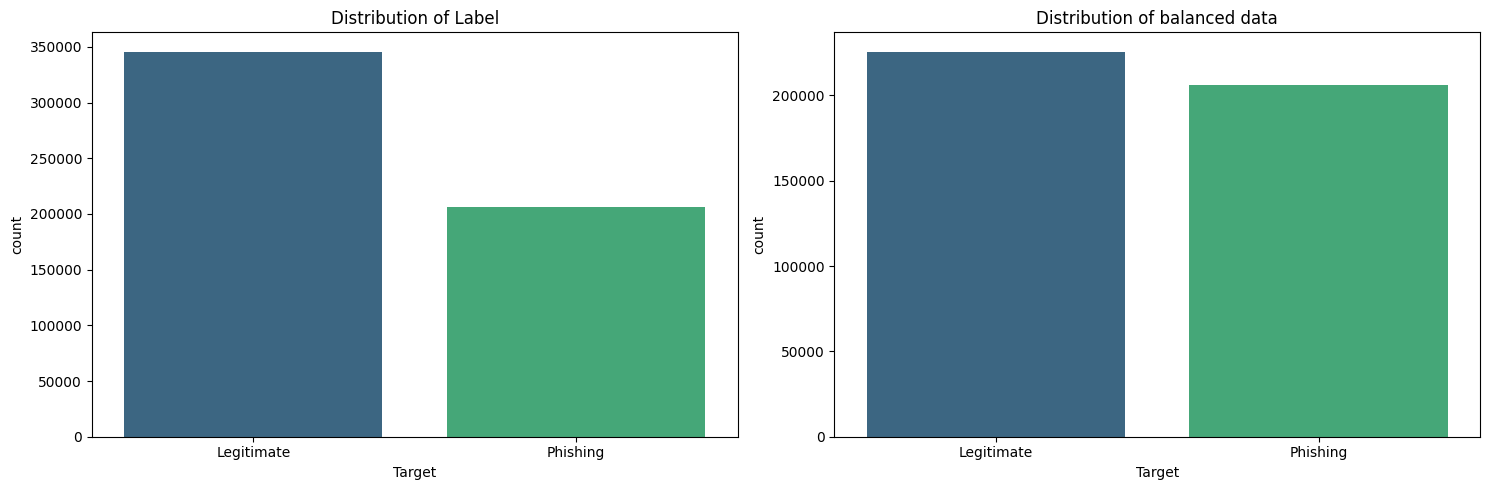

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# distribution of original data
sns.countplot(x='Target', data=df, ax=axes[0], hue='Target',palette='viridis',legend=False)
axes[0].set_title("Distribution of Label")
axes[0].set_xticks([0, 1], ['Legitimate', 'Phishing'])

# distribution of balanced data
sns.countplot(x='Target', hue='Target', data=df_Bal, ax=axes[1],palette='viridis',legend=False)
axes[1].set_title("Distribution of balanced data")
axes[1].set_xticks([0, 1], ['Legitimate', 'Phishing'])

plt.tight_layout()
plt.show()

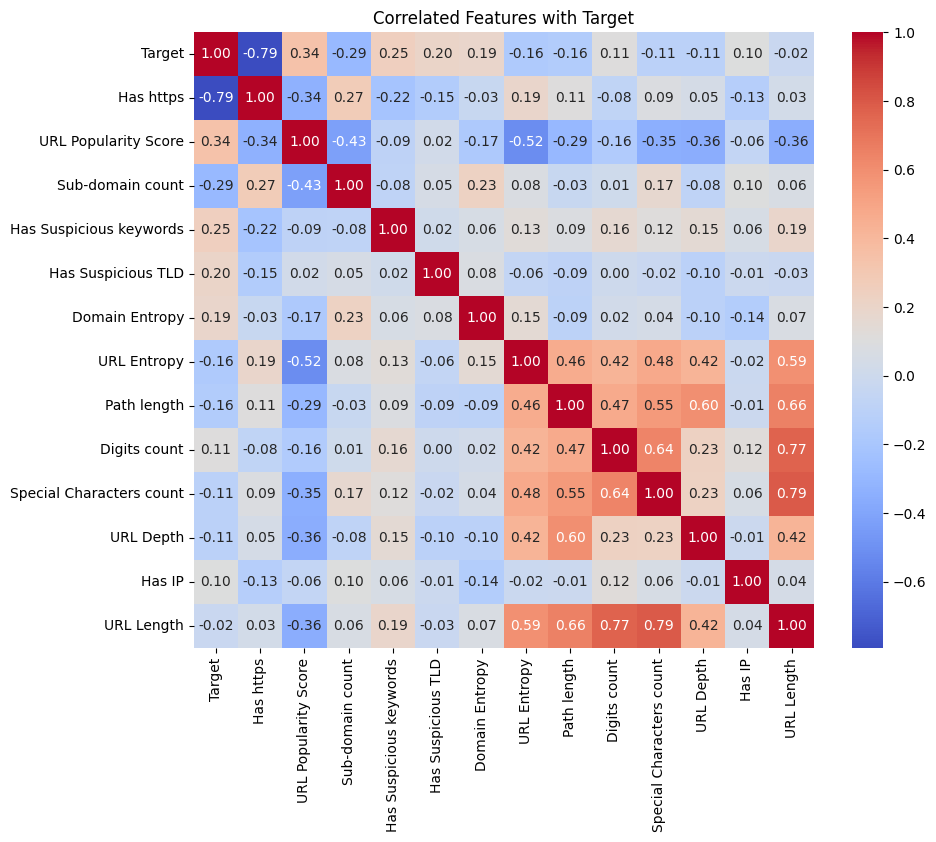

In [35]:
numeric_data = df.select_dtypes(include=[float, int])

correlations_ndata = numeric_data.corr()

# Identify the top features with the highest absolute correlation with the target
top_corr_features = correlations_ndata['Target'].abs().sort_values(ascending=False).head(16).index

# Plot correlation heatmap for the selected top features
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlated Features with Target")
plt.show()

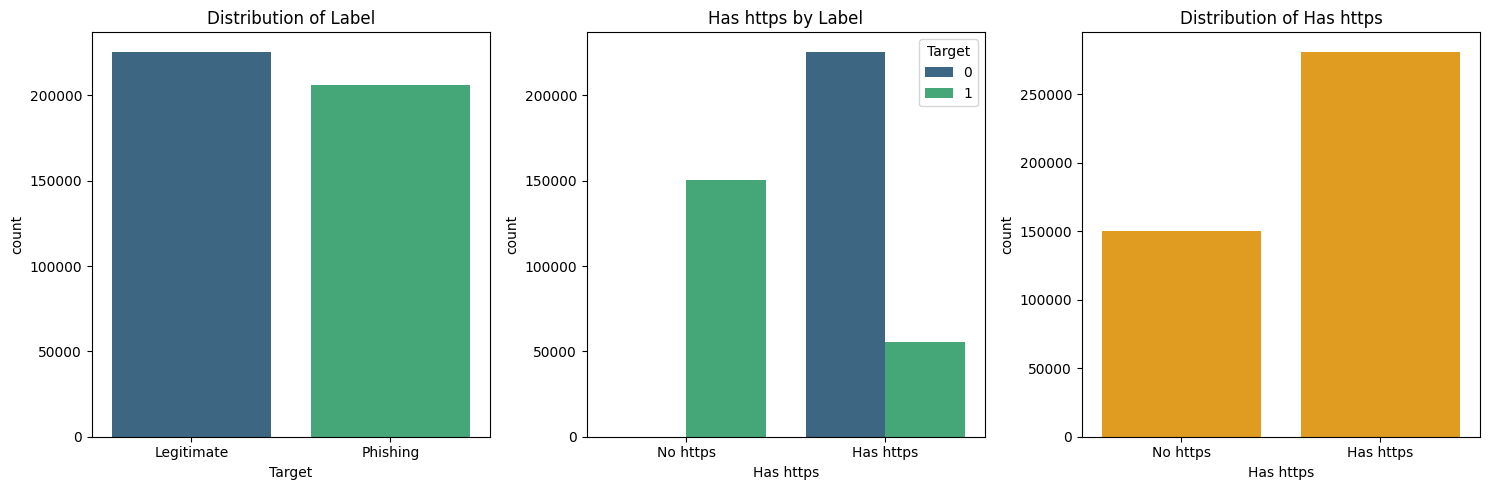

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# distribution of balanced data
sns.countplot(x='Target', data=df_Bal, ax=axes[0], hue='Target',palette='viridis',legend=False)
axes[0].set_title("Distribution of Label")
axes[0].set_xticks([0, 1], ['Legitimate', 'Phishing'])

# distribution of Has https by Label
sns.countplot(x='Has https', hue='Target', data=df_Bal, ax=axes[1],palette='viridis')
axes[1].set_title("Has https by Label")
axes[1].set_xticks([0, 1], ['No https', 'Has https'])

sns.countplot(x='Has https', data=df_Bal, ax=axes[2], color='orange' )
axes[2].set_title("Distribution of Has https")
axes[2].set_xticks([0, 1], ['No https', 'Has https'])

plt.tight_layout()
plt.show()

Observations:    
- This plot confirms that legitimate websites commonly have https, while phishing websites tend to lack it.
- This pattern aligns with real-world scenarios where https is often used as an indicator of security.
- However, a few phishing websites still manage to obtain https to appear more creditable.

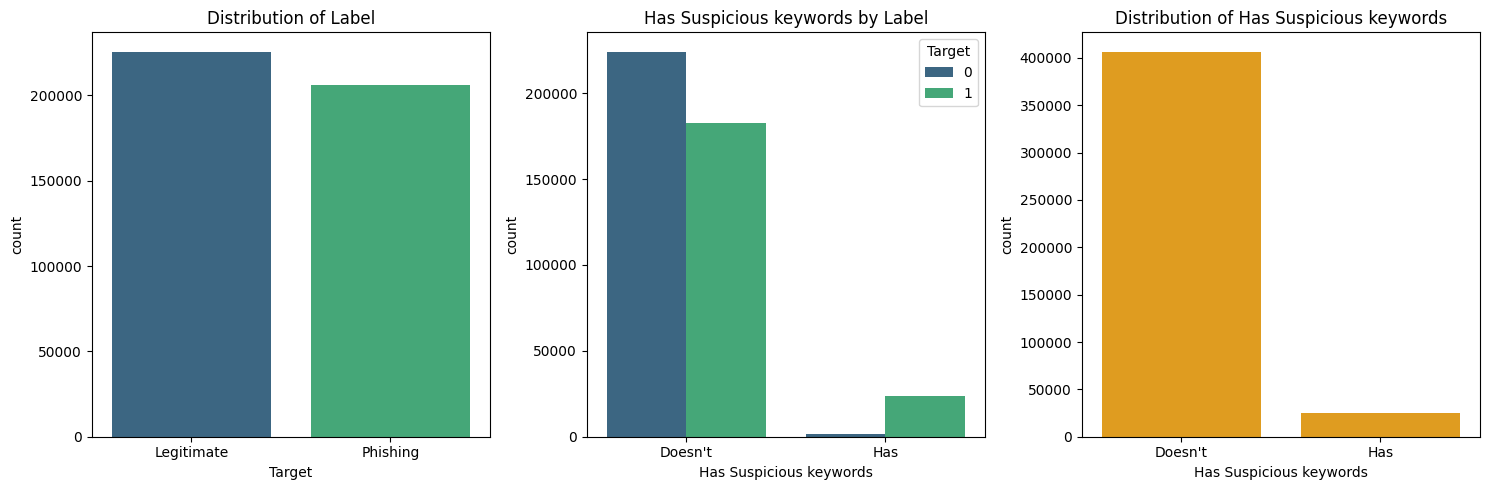

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# distribution of balanced data
sns.countplot(x='Target', data=df_Bal, ax=axes[0], hue='Target',palette='viridis',legend=False)
axes[0].set_title("Distribution of Label")
axes[0].set_xticks([0, 1], ['Legitimate', 'Phishing'])

# distribution of Has Suspicious keywords by Label
sns.countplot(x='Has Suspicious keywords', hue='Target', data=df_Bal, ax=axes[1],palette='viridis')
axes[1].set_title("Has Suspicious keywords by Label")
axes[1].set_xticks([0, 1], ["Doesn't", 'Has'])

sns.countplot(x='Has Suspicious keywords', data=df_Bal, ax=axes[2], color='orange' )
axes[2].set_title("Distribution of Has Suspicious keywords")
axes[2].set_xticks([0, 1], ["Doesn't", 'Has'])

plt.tight_layout()
plt.show()

Observation:   
- Though most websites don't have suspicious words, Phishing websites proportionally have more suspicious words than the Legitimate ones.
- This higher proportion of phishing URLs with suspicious keywords suggests that phishing attempts often rely on eye-catching terms (like "login," "account," or "verify") that may trick users into clicking on them.

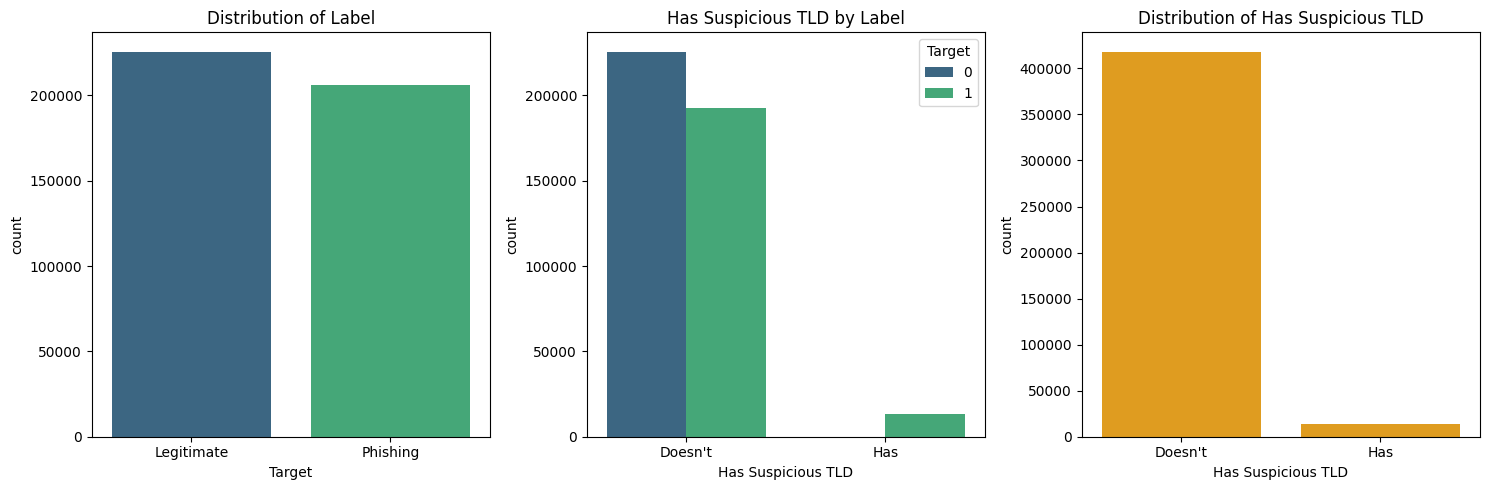

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# distribution of balanced data
sns.countplot(x='Target', data=df_Bal, ax=axes[0], hue='Target',palette='viridis',legend=False)
axes[0].set_title("Distribution of Label")
axes[0].set_xticks([0, 1], ['Legitimate', 'Phishing'])

# distribution of Has Suspicious TLD by Label
sns.countplot(x='Has Suspicious TLD', hue='Target', data=df_Bal, ax=axes[1],palette='viridis')
axes[1].set_title("Has Suspicious TLD by Label")
axes[1].set_xticks([0, 1], ["Doesn't", 'Has'])

sns.countplot(x='Has Suspicious TLD', data=df_Bal, ax=axes[2], color='orange' )
axes[2].set_title("Distribution of Has Suspicious TLD")
axes[2].set_xticks([0, 1], ["Doesn't", 'Has'])

plt.tight_layout()
plt.show()

Observations:
- Phishing websites have proportionally more suspicious TLD than the Legitimate ones.
- This suggest that attackers may seek less common domains to bypass filters, making them harder to identify.

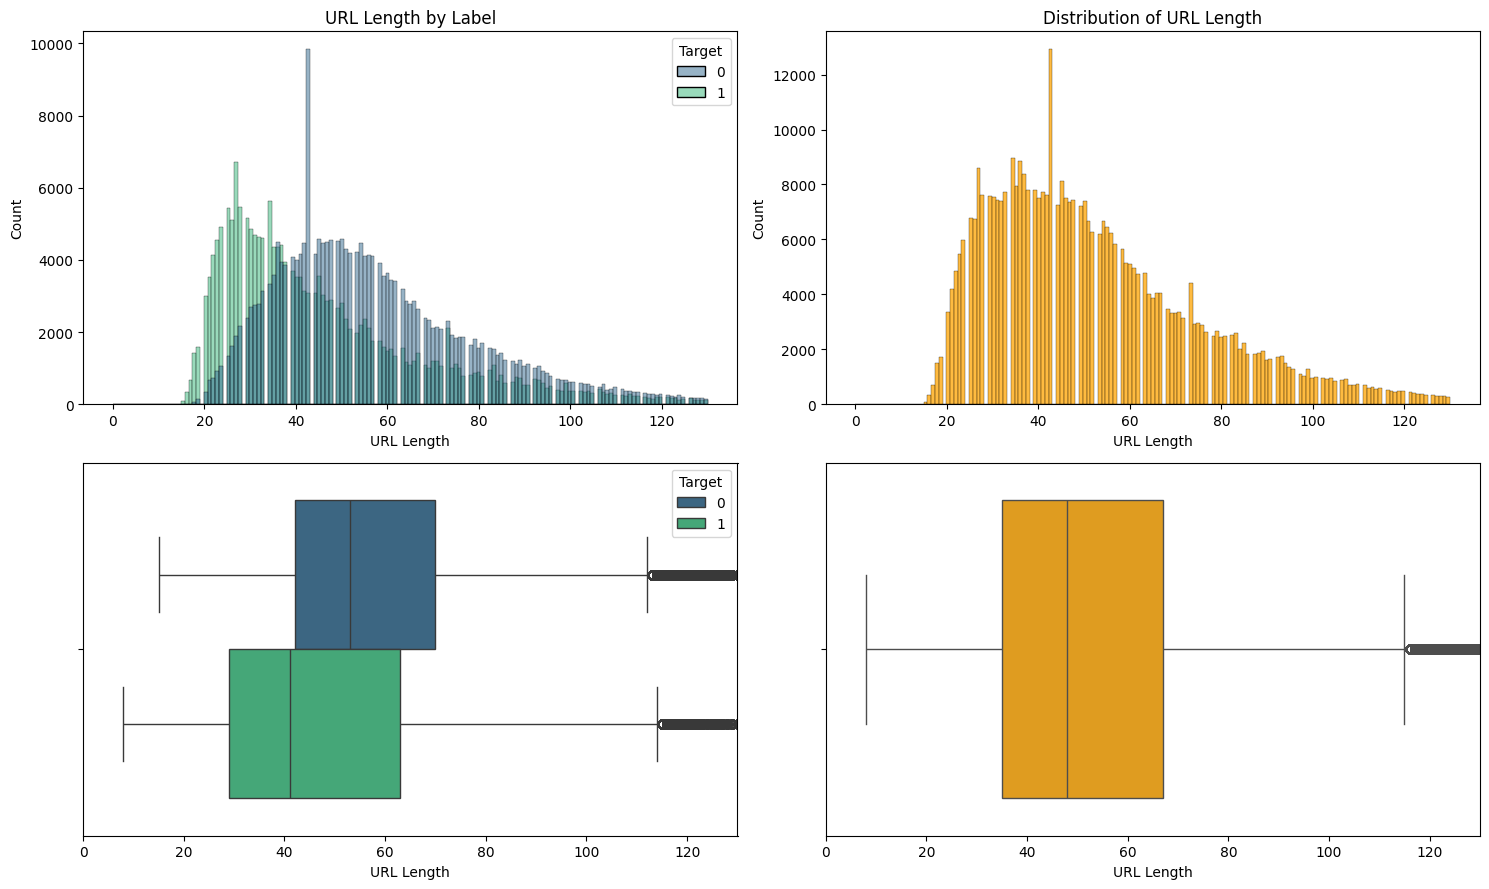

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# distribution of URL Length by Label
sns.histplot(x='URL Length', hue='Target', data=df_Bal, ax=axes[0][0],palette='viridis', binrange=[0,130])
sns.boxplot(x='URL Length', hue='Target', data=df_Bal, ax=axes[1][0],palette='viridis' )
axes[0][0].set_title("URL Length by Label")
axes[1][0].set_xlim(0, 130) 

sns.histplot(x='URL Length', data=df_Bal, ax=axes[0][1], color='orange', binrange=[0,130] )
sns.boxplot(x='URL Length', data=df_Bal, ax=axes[1][1], color='orange')
axes[0][1].set_title("Distribution of URL Length")
axes[1][1].set_xlim(0, 130)

plt.tight_layout()
plt.show()

In [40]:
df_Bal[df_Bal['Target'] == 1]['URL Length'].mode()

0    27
Name: URL Length, dtype: int64

In [41]:
df_Bal['URL Length'].mode()

0    43
Name: URL Length, dtype: int64

In [42]:
df_Bal['URL Length'].describe()

count    431650.000000
mean         57.466934
std          46.975016
min           8.000000
25%          35.000000
50%          48.000000
75%          67.000000
max        6097.000000
Name: URL Length, dtype: float64

Observation:
- The distribution of URL length of Phishing website is more right skewed, concentrated around 27 (mode) the with less variance.

- This suggests that attackers may prefer websites with distinct length patterns, either to mimic legitimate websites or to exploit the longer lengths for embedding keywords or subdomains that might make the URL look credible.

- It is also seen that legitimate URLs have a wider spread than the phishing URLs, this could mean that legitimate sites have more variety in their structure, likely due to genuine and diverse web designs.

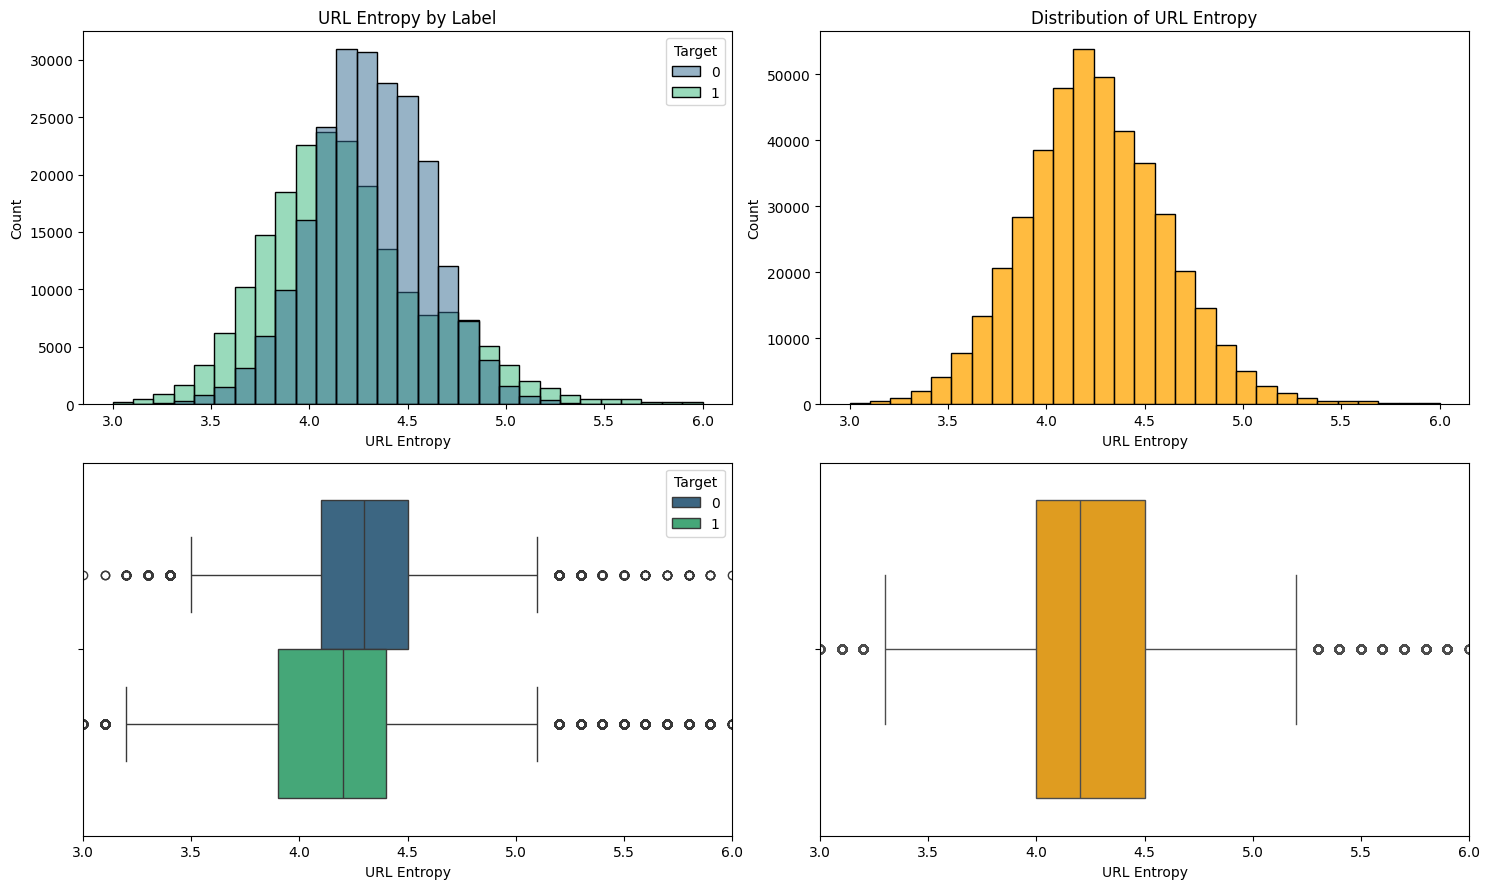

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# distribution of Digits count by Label
sns.histplot(x='URL Entropy', hue='Target', data=df_Bal, ax=axes[0][0],palette='viridis', binrange=[3,6], bins=29)
sns.boxplot(x='URL Entropy', hue='Target', data=df_Bal, ax=axes[1][0],palette='viridis' )
axes[0][0].set_title("URL Entropy by Label")
axes[1][0].set_xlim(3, 6) 

sns.histplot(x='URL Entropy', data=df_Bal, ax=axes[0][1], color='orange',binrange=[3,6], bins=29 )
sns.boxplot(x='URL Entropy', data=df_Bal, ax=axes[1][1], color='orange')
axes[0][1].set_title("Distribution of URL Entropy")
axes[1][1].set_xlim(3, 6)

plt.tight_layout()
plt.show()

In [44]:
df_Bal['URL Entropy'].describe()

count    431650.000000
mean          4.261212
std           0.356723
min           1.300000
25%           4.000000
50%           4.200000
75%           4.500000
max           6.000000
Name: URL Entropy, dtype: float64

Observation:
- Both are normally distributed. 
- Both Phishing and Legitimate URLs have similar patterns, but there seems to be a small difference. More phishing websites have lower URL entropy than expected.
- This suggest that Phishing websites may mimic the Legitimate ones and be designed to be simple and recognizable to exploit user familiarity.

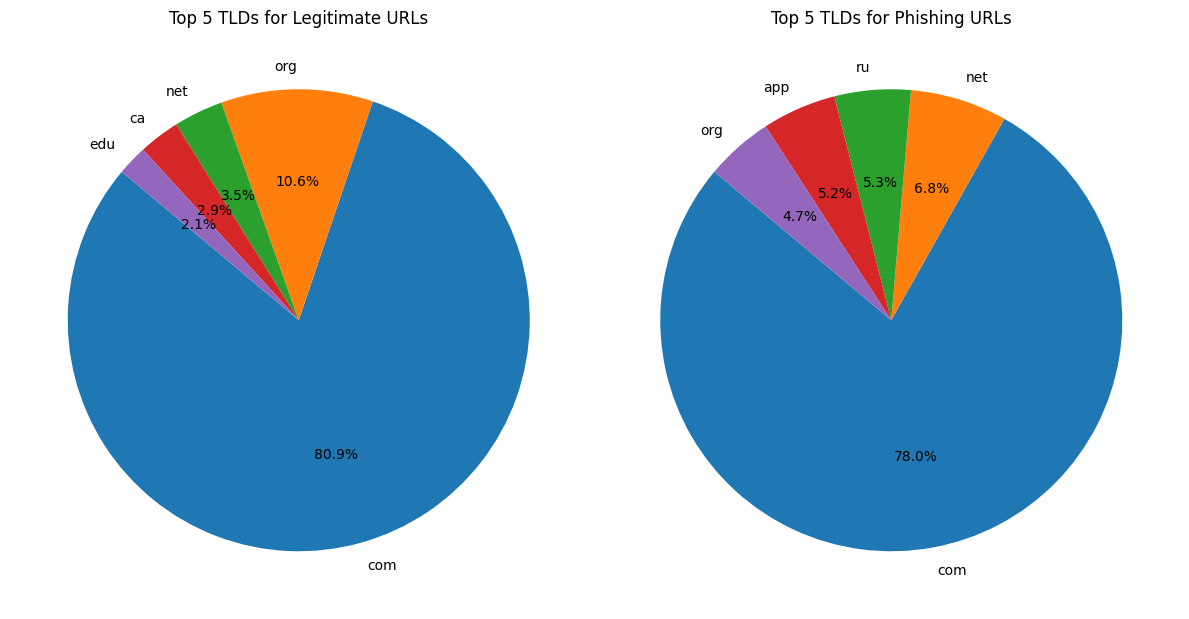

In [45]:
legitimate_tlds = df[df['Target'] == 0]['TLD'].value_counts().head(5)
phishing_tlds = df[df['Target'] == 1]['TLD'].value_counts().head(5)

plt.figure(figsize=(12, 9))

# for legitimate URLs
plt.subplot(1, 2, 1)
plt.pie(legitimate_tlds, labels=legitimate_tlds.index, startangle=140, autopct='%1.1f%%')
plt.title('Top 5 TLDs for Legitimate URLs')

# For phishing URLs
plt.subplot(1, 2, 2)
plt.pie(phishing_tlds, labels=phishing_tlds.index, startangle=140,  autopct='%1.1f%%')
plt.title('Top 5 TLDs for Phishing URLs')

plt.tight_layout()
plt.show()

Observation: 
- It can be seen that Phishing websites use `.com` TLD, even though `.com` is commonly associated with Legitimate websites.
- This may suggest attackers exploiting this association, as users are more likely to click on a `.com` link thinking it's safe or official.

## Model Training

#### Random Forest

In [46]:
df_Bal.columns

Index(['URL', 'URL Length', 'Digits count', 'URL Depth', 'URL Entropy',
       'URL Popularity Score', 'Domain', 'Sub-domain count', 'Domain Entropy',
       'Path length', 'Special Characters count', 'Has https', 'Has IP',
       'Has Suspicious keywords', 'TLD', 'Has Suspicious TLD', 'Label',
       'Target'],
      dtype='object')

In [47]:
X = df_Bal.drop(columns=['Target', 'URL', 'Domain','Label'])
y = df_Bal['Target']

X_ori  = df.drop(columns=['Target', 'URL', 'Domain','Label'])
y_ori = df['Target']

# Encoding categorical columns like 'TLD'
X['TLD'] = le.fit_transform(X['TLD'])
X_ori['TLD'] = le.fit_transform(X_ori['TLD'])

# Scaling features (helps models like Logistic Regression)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_ori = scaler.fit_transform(X_ori)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X1_train, X1_test, y1_train, y1_test = train_test_split(X_ori, y_ori, test_size=0.4, random_state=42)

In [49]:
Random = RandomForestClassifier(n_estimators=100, random_state=42)
Random.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Make predictions on the training and testing sets
y_train_pred = Random.predict(X_train)
y_test_pred = Random.predict(X_test)

print(f"Accuracy on training data: {accuracy_score(y_train_pred, y_train):.3f}", )
print(f"Accuracy on test data: {accuracy_score(y_test_pred, y_test ):.3f}\n")
print(classification_report(y_test, y_test_pred))

Accuracy on training data: 0.994
Accuracy on test data: 0.981

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     67816
           1       0.99      0.97      0.98     61679

    accuracy                           0.98    129495
   macro avg       0.98      0.98      0.98    129495
weighted avg       0.98      0.98      0.98    129495



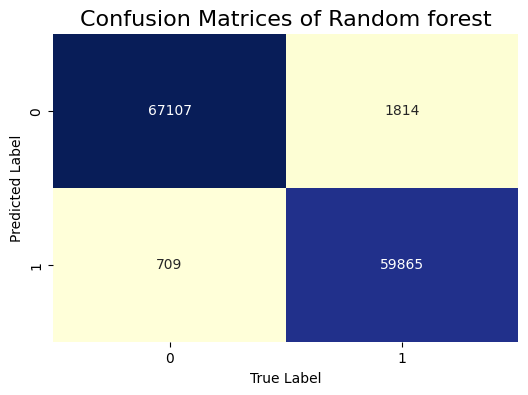

In [35]:
cm = confusion_matrix(y_test, y_test_pred).T
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrices of Random forest', fontsize=16)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

---
Stored in the folder - "models" 

In [36]:
# Saving the fitted LabelEncoder, StandardScaler, and RandomForest model
joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(Random, 'models/random_forest_model.pkl')

['models/random_forest_model.pkl']

---

### Logistic Regression

In [36]:
logreg_model = LogisticRegression(random_state=42, max_iter=1000) 
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [37]:
y_train_pred_logreg = logreg_model.predict(X_train)
y_test_pred_logreg = logreg_model.predict(X_test)

In [38]:
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_logreg))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_logreg))
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_test_pred_logreg))

Training Accuracy: 0.9323592196058315
Testing Accuracy: 0.9308621954515618

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94     67816
           1       0.96      0.89      0.92     61679

    accuracy                           0.93    129495
   macro avg       0.93      0.93      0.93    129495
weighted avg       0.93      0.93      0.93    129495



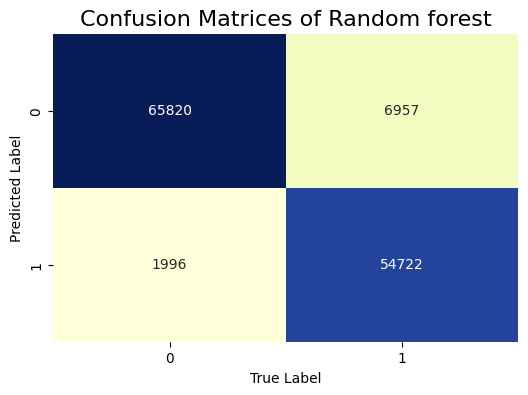

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_logreg).T
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrices of Random forest', fontsize=16)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

### XGBoost

In [40]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Suitable for binary classification tasks
    eval_metric='logloss',        # Log loss evaluation metric
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [41]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

In [42]:
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_xgb):.3f}", )
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.3f}", )
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_test_pred_xgb))

Training Accuracy: 0.984
Testing Accuracy: 0.981

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     67816
           1       0.99      0.97      0.98     61679

    accuracy                           0.98    129495
   macro avg       0.98      0.98      0.98    129495
weighted avg       0.98      0.98      0.98    129495



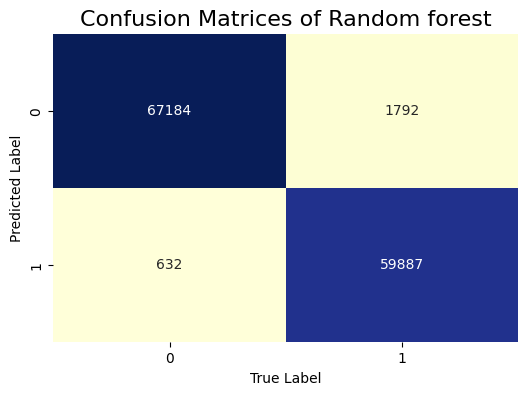

In [43]:
cm = confusion_matrix(y_test, y_test_pred_xgb).T
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrices of Random forest', fontsize=16)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

### Naive Bayes 

In [44]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [45]:
y_train_pred_nb = nb_model.predict(X_train)
y_test_pred_nb = nb_model.predict(X_test)

In [46]:
print("Naive Bayes Results:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_nb))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_nb))
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_test_pred_nb))

Naive Bayes Results:
Training Accuracy: 0.8891396799655806
Testing Accuracy: 0.8884126800262558

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     67816
           1       0.98      0.78      0.87     61679

    accuracy                           0.89    129495
   macro avg       0.91      0.88      0.89    129495
weighted avg       0.90      0.89      0.89    129495



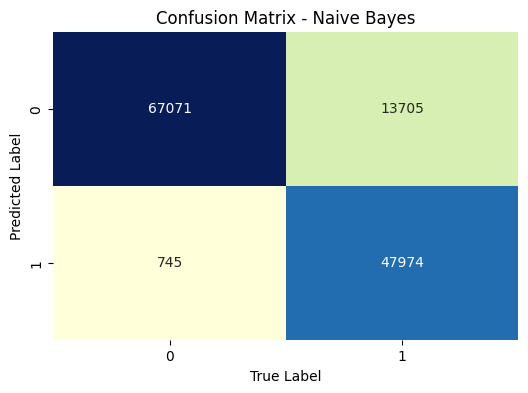

In [47]:
cm = confusion_matrix(y_test, y_test_pred_nb).T
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

---
Stored in the folder - "models"

In [54]:
# For XGBoost
joblib.dump(xgb_model, 'models/xgboost_model.pkl')

# For Logistic Regression
joblib.dump(logreg_model, 'models/logistic_regression_model.pkl')

# For Naive Bayes
joblib.dump(nb_model, 'models/naive_bayes_model.pkl')

['models/naive_bayes_model.pkl']

---

## Model Performance

In [ ]:
# Dictionary to store models and their predictions

models = {
    "Random Forest": Random,
    "XGBoost": xgb_model,
    "Logistic Regression": logreg_model,
    "Naive Bayes": nb_model
    
}

# List to store the metrics for each model
metrics = []

# Calculate metrics for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Append results to the metrics list
    metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    })

# Convert list to DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Accuracy,F1 Score,Recall,Precision
0,Random Forest,0.980517,0.980507,0.980517,0.980641
1,XGBoost,0.981281,0.981272,0.981281,0.981420
2,Logistic Regression,0.930862,0.930634,0.930862,0.933176
3,Naive Bayes,0.888413,0.886729,0.888413,0.903863


In [49]:
sorted_result=metrics_df.sort_values(by=['Accuracy', 'F1 Score'],ascending=False).reset_index(drop=True)
sorted_result

,Model,Accuracy,F1 Score,Recall,Precision
0,XGBoost,0.981281,0.981272,0.981281,0.981420
1,Random Forest,0.980517,0.980507,0.980517,0.980641
2,Logistic Regression,0.930862,0.930634,0.930862,0.933176
3,Naive Bayes,0.888413,0.886729,0.888413,0.903863


## URL Prediction

In [5]:
import joblib
import pandas as pd

# Load the saved LabelEncoder and StandardScaler
le = joblib.load('models/label_encoder.pkl')
scaler = joblib.load('models/scaler.pkl')

# Load a specific model
model = joblib.load('models/random_forest_model.pkl')  # Change this to any other model as needed

def extract_features(url):
    features = {
        'URL Length': get_url_len(url),
        'Digits count': count_digits(url),
        'URL Depth': count_url_depth(url),
        'URL Entropy': entropy(url),
        'URL Popularity Score': popularity_score(url),
        'Domain': get_domain(url),
        'Sub-domain count': count_subdomain(url),
        'Domain Entropy': calculate_entropy(url),
        'Path length': path_length(url),
        'Special Characters count': count_special_char(url),
        'Has https': 1 if 'https' in url else 0,
        'Has IP': has_ip(url),
        'Has Suspicious keywords': has_suspicious_keywords(url),
        'TLD': get_tld(url),
        'Has Suspicious TLD': has_suspicious_tld(url)
    }
    return features

def classify_url(url):
    
    if not (url.startswith('http://') or url.startswith('https://')):
        raise ValueError("Invalid URL: URL must start with http:// or https://")

    features = extract_features(url)
    df = pd.DataFrame([features])
    df = df.drop(columns=['Domain']) 

    # Encode 'TLD' using the loaded LabelEncoder
    df['TLD'] = le.transform(df['TLD'])
  
    # Scale features using the loaded StandardScaler
    df_scaled = scaler.transform(df) 

    prediction = model.predict(df_scaled)
    return "Phishing" if prediction[0] == 1 else "Legitimate"

# Input your website
url_to_test = "https://www.quora.com/Is-there-a-comprehensive-list-of-scam-websites-available-online-If-not-what-are-the-reasons-for-this"
# url = 'https://support.google.com/chrome/answer/99020?hl=en&co=GENIE.Platform%3DDesktop'
url = 'https://www.google.com'
result = classify_url(url)

print(f"The URL '{url}' is {result}")

The URL 'https://www.google.com' is Legitimate
